# Life Cycle Analysis of 1 kg of PCB-A

## Initialization

In [152]:
import brightway2 as bw
from brightway2 import *
import os 
import lca_algebraic as agb
import bw2io
from bw2data.parameters import ActivityParameter, DatabaseParameter, ProjectParameter, Group  

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sympy import init_printing
init_printing() # Pretty print for Sympy

### Setting the project

In [153]:
list(bw.projects) # print current projects

# if necessary, delete previous project with
# bw.projects.delete_project('project', delete_dir=True)

[Project: default, Project: lca_pcb_test]

In [154]:
bw.projects.set_current('lca_pcb_test') # Open a brightway project 
bw.bw2setup() # Importing elementary flows, LCIA methods and some other data

Biosphere database already present!!! No setup is needed


## Loading background ecoinvent database

In [155]:
if 'ecoinvent_v3.9.1_cutoff_ecoSpold02' in bw.databases:
    print("Database has already been imported.")
else:
    fpei39cut = r"C:\Users\lebrunjus\Desktop\Brightway\LCA_PCB\ecoinvent_v3.9.1_cutoff_ecoSpold02\datasets"
    ei39cut = bw.SingleOutputEcospold2Importer(fpei39cut, 'ecoinvent_v3.9.1_cutoff_ecoSpold02')
    ei39cut
    ei39cut.apply_strategies()
    ei39cut.statistics()
    ei39cut.write_database()

# agb.resetParams() # Reset the definition of all parameters 
# del bw.databases["ecoinvent_v3.9.1_cutoff_ecoSpold02"]

Database has already been imported.


In [156]:
USER_DB = 'Foreground_pcb_fr4'
agb.resetDb(USER_DB) #cleanup the whole foreground model each time, and redefine it in the notebook

# Parameters are stored at project level : Reset them also
# You may remove this line if you import a project and parameters from an external source (see loadParam(..))
agb.resetParams()

[WARNING] Db Foreground_pcb_fr4 was here. Reseting it


In [157]:
# List imported databases
agb.list_databases()

,backend,nb_activities,type
name,,,
biosphere3,sqlite,4709,biosphere
ecoinvent_v3.9.1_cutoff_ecoSpold02,sqlite,21238,background
Foreground_pcb_fr4,sqlite,0,foreground


## Select LCIA methods

**bw.methods** is a brightway dictionnary that contains all LCIA methods and impacts categories that were imported when initialising the notebook.

Objects in **bw.methods** are triplet (LCIA method, endpoint category, midpoint category) that corresponds 
to impacts categories calculated with a given LCIA method.

In [158]:
print('Brightway LCIA methods and impact categories')
list(bw.methods) #See all triplets of bw.methods

# Search through the methods
# list_LCIA_methods = [m[0] for m in bw.methods] # See all the LCIA methods available in Brightway 2
# list_LCIA_methods = [m[0] for m in bw.methods if "ReCiPe" in str(m)] # See all the LCIA methods that were imported that contains ReCiPe in their name"
# list_LCIA_methods = [m[0] for m in bw.methods if not "no LT" in str(m) and not'obsolete' in str(m)] # See all the LCIA methods that were imported excluding the one containing keywords such as "no LT" or "obsolete"
# list_LCIA_methods = [*set(list_LCIA_methods)]
# list_LCIA_methods

Brightway LCIA methods and impact categories


[('CML v4.8 2016 no LT',
  'acidification no LT',
  'acidification (incl. fate, average Europe total, A&B) no LT'),
 ('CML v4.8 2016 no LT',
  'climate change no LT',
  'global warming potential (GWP100) no LT'),
 ('CML v4.8 2016 no LT',
  'ecotoxicity: freshwater no LT',
  'freshwater aquatic ecotoxicity (FAETP inf) no LT'),
 ('CML v4.8 2016 no LT',
  'ecotoxicity: marine no LT',
  'marine aquatic ecotoxicity (MAETP inf) no LT'),
 ('CML v4.8 2016 no LT',
  'ecotoxicity: terrestrial no LT',
  'terrestrial ecotoxicity (TETP inf) no LT'),
 ('CML v4.8 2016 no LT',
  'energy resources: non-renewable no LT',
  'abiotic depletion potential (ADP): fossil fuels no LT'),
 ('CML v4.8 2016 no LT',
  'eutrophication no LT',
  'eutrophication (fate not incl.) no LT'),
 ('CML v4.8 2016 no LT',
  'human toxicity no LT',
  'human toxicity (HTP inf) no LT'),
 ('CML v4.8 2016 no LT',
  'material resources: metals/minerals no LT',
  'abiotic depletion potential (ADP): elements (ultimate reserves) no LT')

In [159]:
# Pick the LCIA method 
LCIA_method = 'EF v3.0 no LT'

#Methods selection
#LOP_ReCiPe = [m for m in bw.methods if 'ReCiPe 2016 v1.03' in str(m) and  'midpoint (H)' in str(m) and 'land use' in str(m) and 'agricultural land occupation (LOP)' in str(m)][0]
#GWP_IPCC = [m for m in bw.methods if 'IPCC 2021 no LT' in str(m) and  'climate change no LT' in str(m) and  'global warming potential (GWP100) no LT' in str(m)][0]
#GWP_EF = [m for m in bw.methods if 'EF v3.0' in str(m) and  'climate change' in str(m) and  'global warming potential (GWP100)' in str(m)][0]

## Select impact categories

**impact_categories** are triplets (LCIA method, endpoint category, midpoint category).

To do : update the name of the endpoint and midpoint category in the triplet and the name of impact_categories

In [160]:
list_impact_categories=agb.findMethods("", LCIA_method)
nb_impacts=len(list_impact_categories)

print(f"There are {nb_impacts} impacts categories calculated with the LCIA method : '{LCIA_method}' that are :")
list_impact_categories

There are 28 impacts categories calculated with the LCIA method : 'EF v3.0 no LT' that are :


[('EF v3.0 no LT', 'acidification no LT', 'accumulated exceedance (AE) no LT'),
 ('EF v3.0 no LT',
  'climate change no LT',
  'global warming potential (GWP100) no LT'),
 ('EF v3.0 no LT',
  'climate change: biogenic no LT',
  'global warming potential (GWP100) no LT'),
 ('EF v3.0 no LT',
  'climate change: fossil no LT',
  'global warming potential (GWP100) no LT'),
 ('EF v3.0 no LT',
  'climate change: land use and land use change no LT',
  'global warming potential (GWP100) no LT'),
 ('EF v3.0 no LT',
  'ecotoxicity: freshwater no LT',
  'comparative toxic unit for ecosystems (CTUe) no LT'),
 ('EF v3.0 no LT',
  'ecotoxicity: freshwater, inorganics no LT',
  'comparative toxic unit for ecosystems (CTUe) no LT'),
 ('EF v3.0 no LT',
  'ecotoxicity: freshwater, metals no LT',
  'comparative toxic unit for ecosystems (CTUe) no LT'),
 ('EF v3.0 no LT',
  'ecotoxicity: freshwater, organics no LT',
  'comparative toxic unit for ecosystems (CTUe) no LT'),
 ('EF v3.0 no LT',
  'energy resou

In [161]:
# let's focus on only 3 impact categories to start
climate = (LCIA_method, 'climate change no LT','global warming potential (GWP100) no LT')
water = (LCIA_method, 'ecotoxicity: freshwater no LT','comparative toxic unit for ecosystems (CTUe) no LT')
ressources = (LCIA_method, 'material resources: metals/minerals no LT','abiotic depletion potential (ADP): elements (ultimate reserves) no LT')

impacts = [climate, water, ressources]

nb_impacts = len(impacts)
print(f"We have selected {nb_impacts} impacts categories calculated with the LCIA method : '{LCIA_method}' that are :")
print(" ")
for m in impacts : print(m[1],">", m[-1])

We have selected 3 impacts categories calculated with the LCIA method : 'EF v3.0 no LT' that are :
 
climate change no LT > global warming potential (GWP100) no LT
ecotoxicity: freshwater no LT > comparative toxic unit for ecosystems (CTUe) no LT
material resources: metals/minerals no LT > abiotic depletion potential (ADP): elements (ultimate reserves) no LT


In [162]:
# Test if the triplet you have just defined are methods in bw.methods. If no errors, you good :)
bw.methods[climate]
bw.methods[water]
bw.methods[ressources]

{'description': '',
 'filename': 'LCIA_Implementation_3.9.xlsx',
 'unit': 'kg Sb-Eq',
 'abbreviation': 'ef-v30-no-ltma.1613a0a7bd476ef82b3b3f12836b502f',
 'num_cfs': 148}

## Parameters

In [163]:
agb.resetParams() # Reset the definition of all parameters 

b = agb.newFloatParam(
    'b',
    default=1.0, 
    min=0, max=1, std=0.2, 
    distrib=agb.DistributionType.NORMAL,
    description="testb")

a = agb.newFloatParam(
    'a', 
    default=0.5, min=0.2, max=2,  
    distrib=agb.DistributionType.TRIANGLE,
    description="test",
    label="test")

In [164]:
# Load parameters previously  persisted in the dabatase.
agb.loadParams()

[WARNING] [ParamRegistry] Param b was already defined in '<project>' : overriding.
[WARNING] [ParamRegistry] Param b was already defined in '<project>' : overriding.
[WARNING] Variable 'b' was already defined : overidding it with param.
[WARNING] [ParamRegistry] Param a was already defined in '<project>' : overriding.
[WARNING] [ParamRegistry] Param a was already defined in '<project>' : overriding.
[WARNING] Variable 'a' was already defined : overidding it with param.


## Activities

In [165]:
# Biosphere activities
heat = agb.findBioAct('Heat, waste', categories=['air']) 

# Technosphere activities
pcb_produ = agb.findTechAct("market for printed wiring board, surface mounted, unspecified, Pb free", loc="GLO")

In [166]:
heat_act = agb.newActivity(USER_DB, # virtual activity ! to change
    "Heat wasted during pcb manufacturing", 
    "MJ", 
    exchanges= {
        heat: 0.2 
    })

pcb_act = agb.newActivity(USER_DB, # virtual activity ! to change
    "1 kg of printed wiring board", 
    "kg", 
    exchanges= {
        pcb_produ : 1.0 
    })

agb.printAct(heat_act, pcb_act) 
#agb.printAct(heat_act, b=0.2) 

### Define the model

In [167]:
total_inventory = agb.newActivity(
    USER_DB, 
    "total_inventory", 
    "kg", 
    {
    heat_act : b, 
    pcb_act: b
    })

# total_inventory_pcb.addExchanges({ pcb_product : 1.0 })

agb.printAct(total_inventory)
#agb.printAct(total_inventory_pcb, a=1.5, b=0.2)

total_inventory (1.000000 kg)  \
                                                                         input   
1 kg of printed wiring board                  1 kg of printed wiring board{FG}   
Heat wasted during pcb manufacturing  Heat wasted during pcb manufacturing{FG}   

                                                  
                                     amount unit  
1 kg of printed wiring board              b   kg  
Heat wasted during pcb manufacturing      b   MJ

In [168]:
# agb.list_databases() # to check if the activity was added

## Functional unit

In [169]:
#f_unit = {total_inventory_pcb:1} # 1 kg of PCB-A
f_unit = 1.0
print(f_unit)

1.0


## Compute impacts

In [170]:
agb.compute_impacts(
    total_inventory, 
    impacts, 
    functional_unit = f_unit,
    a = 1.0,
    b = 1.0
)

[INFO] Db changed recently, clearing cache expr
[INFO] Db changed recently, clearing cache lcia


,climate change no LT - global warming potential (GWP100) no LT[kg CO2-Eq],ecotoxicity: freshwater no LT - comparative toxic unit for ecosystems (CTUe) no LT[CTUe],material resources: metals/minerals no LT - abiotic depletion potential (ADP): elements (ultimate reserves) no LT[kg Sb-Eq]
total_inventory,314.636,"41,514.8",0.132547


## Sensitivity analysis

`oat_matrix(model, impacts)` shows a matrix of impacts x parameters colored according to the variation of the impact in the bounds of the parameter.

In [171]:
### Debugging
# print(impacts)
# print(len(impacts))

# agb.printAct(total_inventory)

In [172]:
help(agb.oat_matrix)

Help on function oat_matrix in module lca_algebraic.stats:

oat_matrix(model: bw2data.backends.peewee.proxies.Activity, impacts, functional_unit: Union[float, sympy.core.basic.Basic, sympy.physics.units.quantities.Quantity] = 1, n=10, title='Impact variability (% of mean)', name_type=<NameType.LABEL: 'label'>)
    This function generates a heat map of relative the variance of impacts
    for each parameter varying along its min/max values.
    
    Parameters
    ----------
    model:
        Root activity of the inventory
    
    impacts:
        Impact variabilityList of impact methods keys (tuples)
    
    functional_unit:
        Float value of expression by which to divide each impact.



In [173]:
print(impacts)

[('EF v3.0 no LT', 'climate change no LT', 'global warming potential (GWP100) no LT'), ('EF v3.0 no LT', 'ecotoxicity: freshwater no LT', 'comparative toxic unit for ecosystems (CTUe) no LT'), ('EF v3.0 no LT', 'material resources: metals/minerals no LT', 'abiotic depletion potential (ADP): elements (ultimate reserves) no LT')]


[INFO] Db changed recently, clearing cache expr


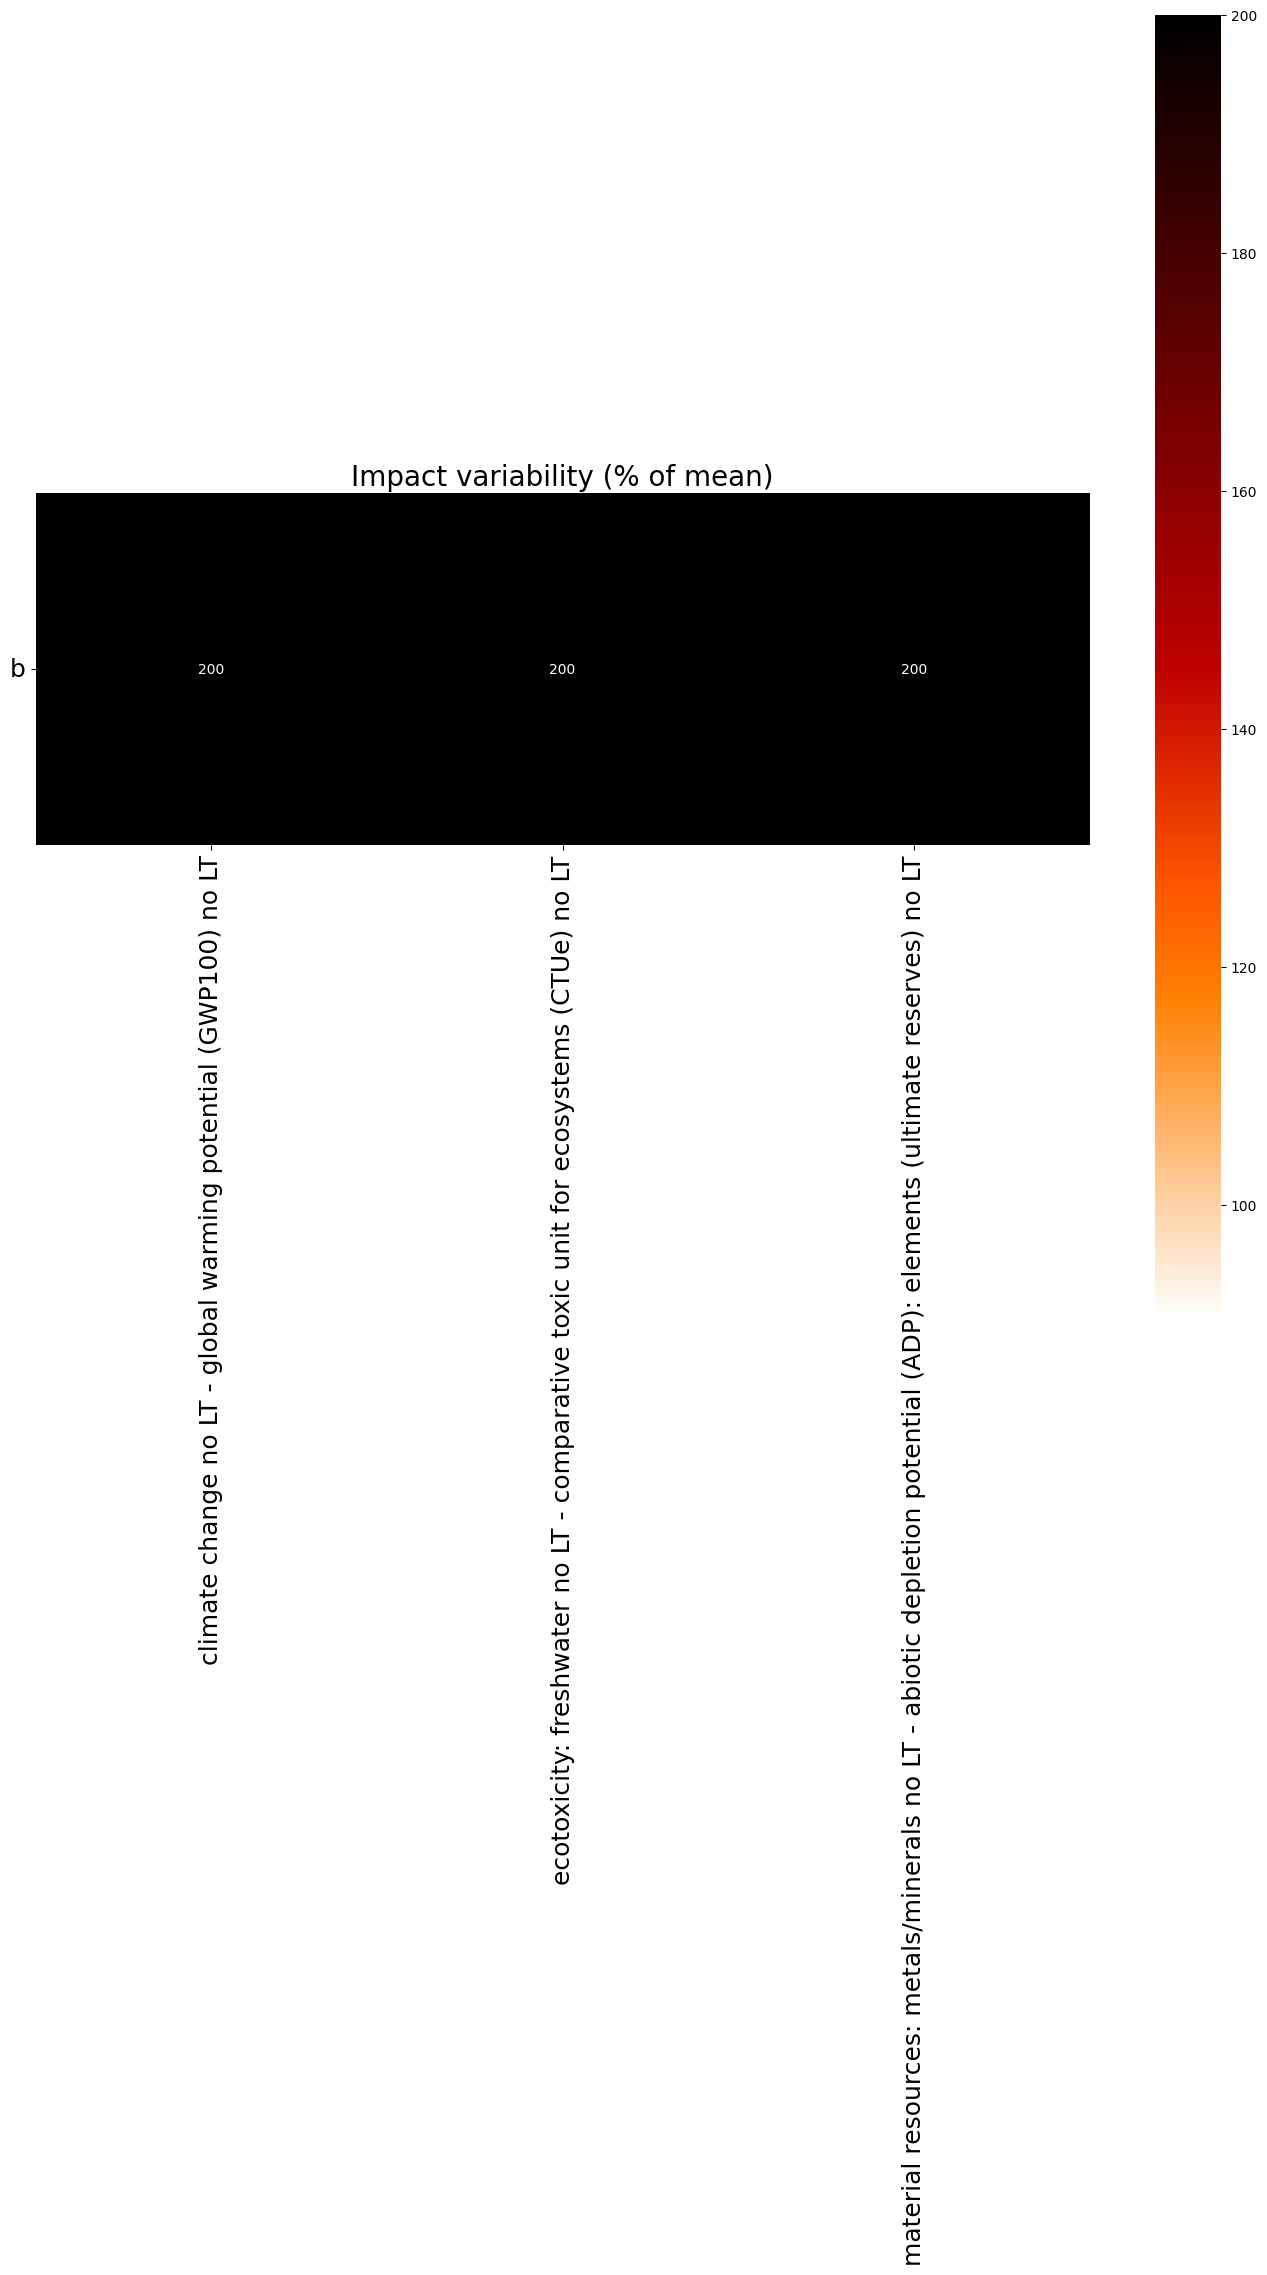

In [174]:
agb.oat_matrix(
    total_inventory, 
    impacts, 
    f_unit)

In [175]:
agb.oat_dashboard(
    total_inventory, 
    impacts, 
    f_unit,
    
    # Optionnal layout parameters
    figspace=(0.5,0.5),
    figsize=(15, 15),
    sharex=True)

interactive(children=(Dropdown(description='param', options=('b',), value='b'), Output()), _dom_classes=('widg…

## Monte Carlo simulation

In [176]:
# Show sobol indices 
agb.incer_stochastic_matrix(
    total_inventory, 
    impacts, 
    functional_unit=f_unit)

Generating samples ...
Transforming samples ...
Processing Sobol indices ...
Processing sobol for ('EF v3.0 no LT', 'climate change no LT', 'global warming potential (GWP100) no LT')
Processing sobol for ('EF v3.0 no LT', 'ecotoxicity: freshwater no LT', 'comparative toxic unit for ecosystems (CTUe) no LT')
Processing sobol for ('EF v3.0 no LT', 'material resources: metals/minerals no LT', 'abiotic depletion potential (ADP): elements (ultimate reserves) no LT')


D:\Users\Justine\Anaconda\envs\lca_algebraic_CGM\lib\site-packages\SALib\util\__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


interactive(children=(Dropdown(description='indice', options=('s1', 'st'), value='s1'), Dropdown(description='…

Generating samples ...
Transforming samples ...


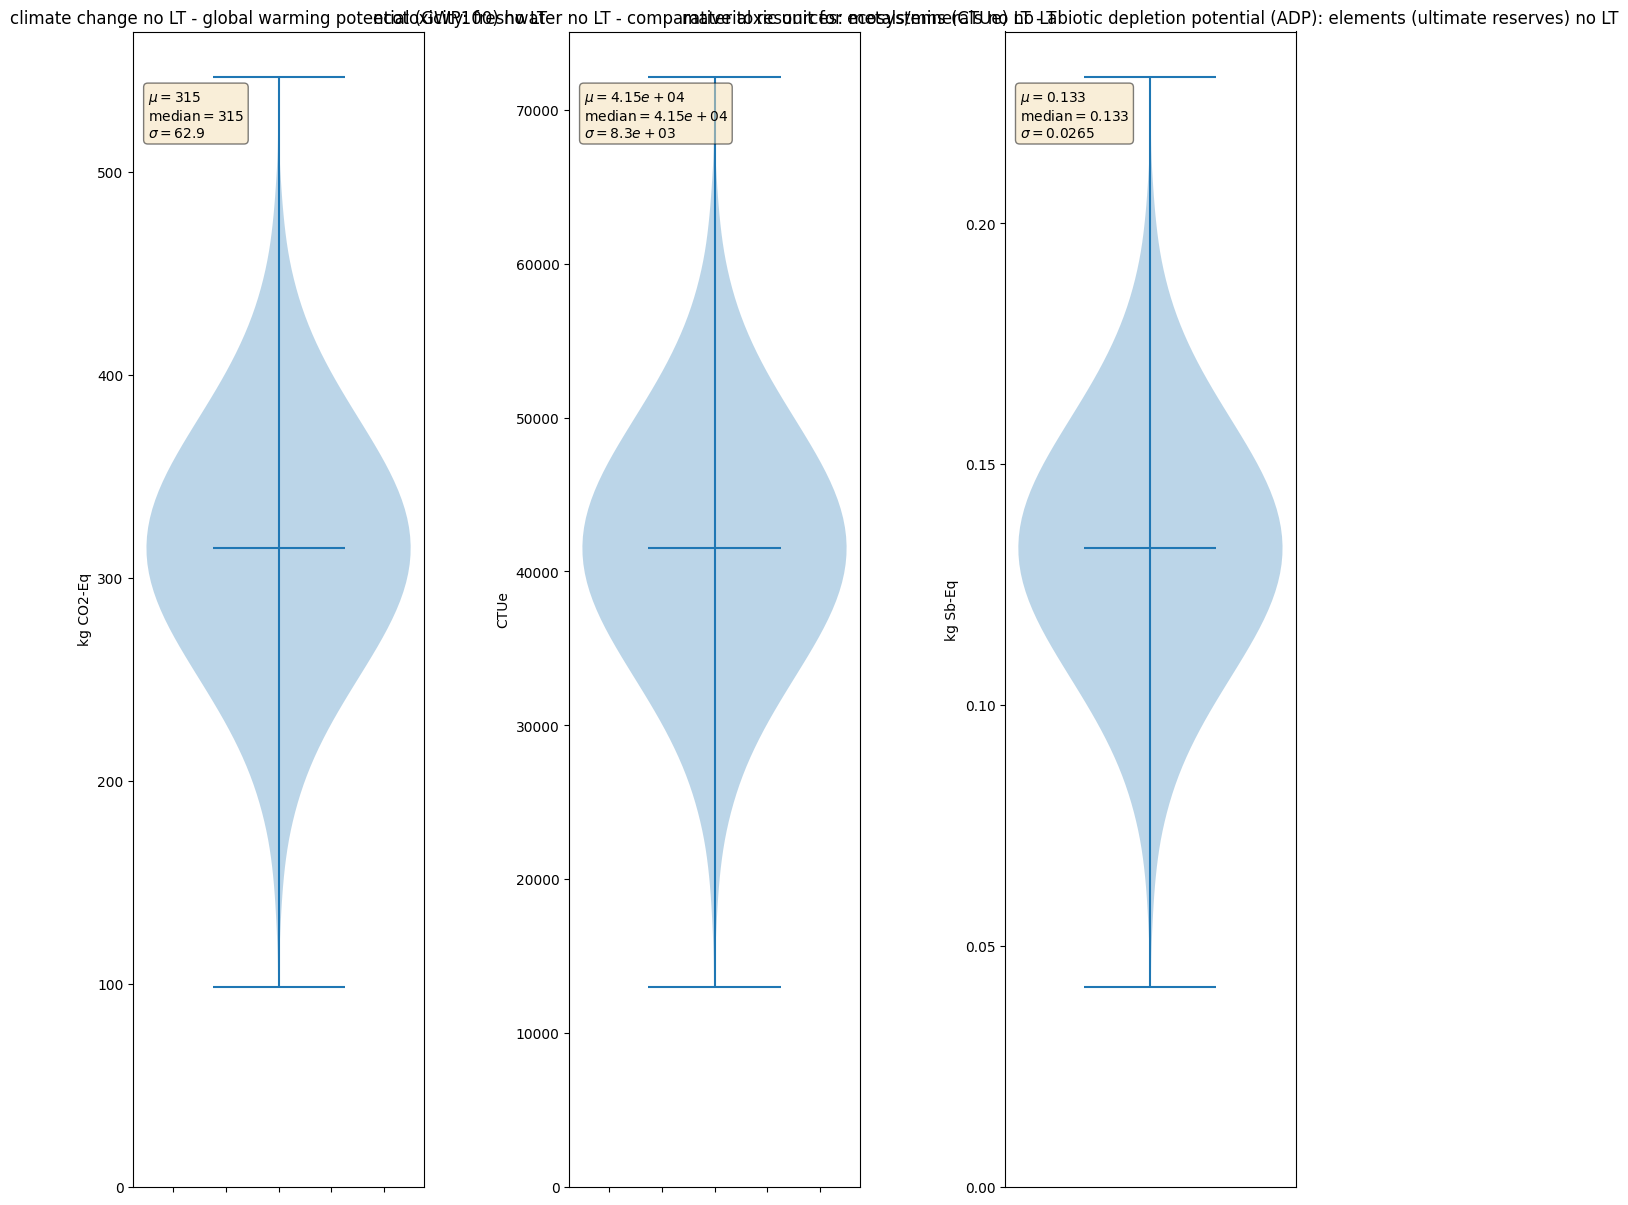

In [177]:
agb.incer_stochastic_violin(
    total_inventory, impacts,
    functional_unit=f_unit,
    
    # Optionnal layout parameters
    figspace=(0.5,0.5),
    figsize=(15, 15),
    sharex=True, 
    nb_cols=3)

Generating samples ...
Transforming samples ...


,climate change no LT - global warming potential (GWP100) no LT [kg CO2-Eq / ],ecotoxicity: freshwater no LT - comparative toxic unit for ecosystems (CTUe) no LT [CTUe / ],material resources: metals/minerals no LT - abiotic depletion potential (ADP): elements (ultimate reserves) no LT [kg Sb-Eq / ]
median,314.636,"41,514.8",0.132547
std,62.9215,"8,302.22",0.0265071
p,"[211.14997594979806, 418.13263694391543]","[27860.304406230658, 55170.75005590855]","[0.08895165113413499, 0.17614772761363726]"
mean,314.636,"41,514.8",0.132547
var,0.199982,0.199982,0.199982


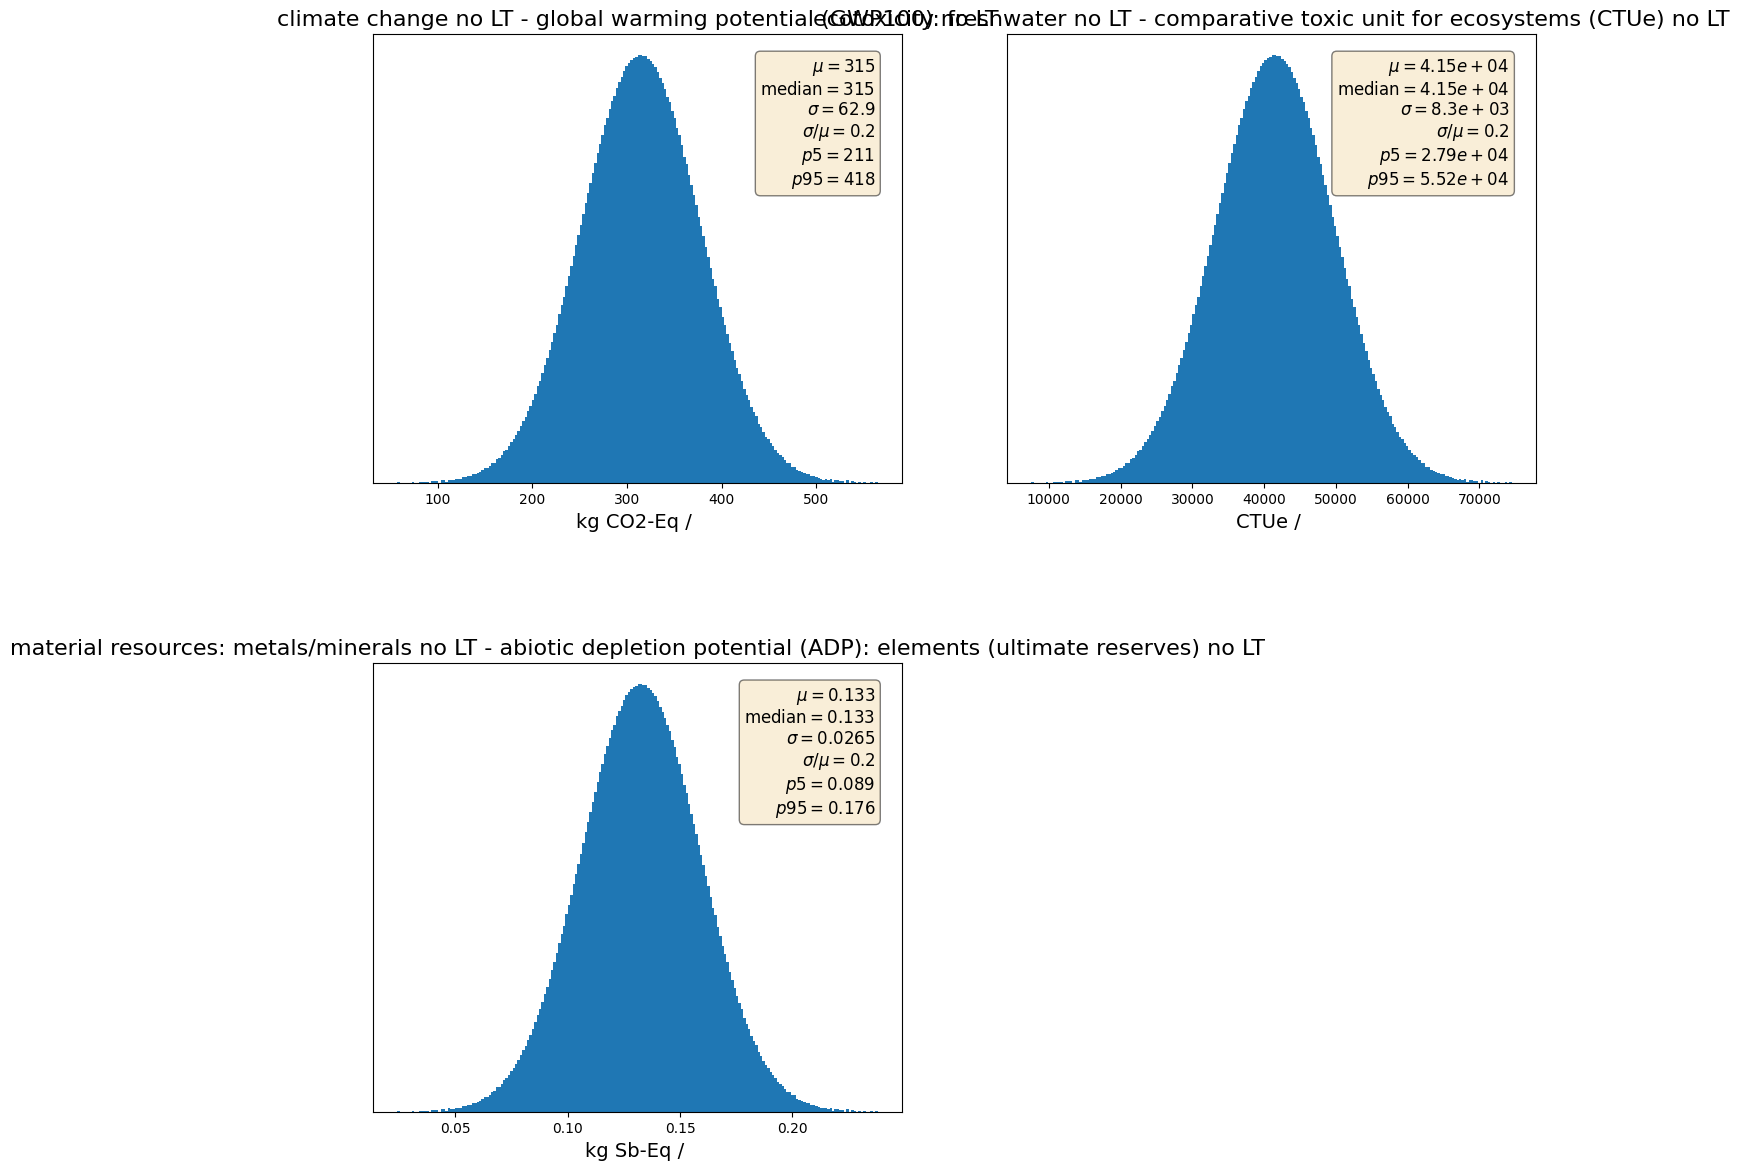

In [178]:
##### Alternatively, graphs can be shown horizontally, together with a box of statistical outcomes
agb.distrib(
    total_inventory, 
    impacts,
    functional_unit=f_unit,
    
    # Optionnal layout parameters
    height=7, width=15,
    nb_cols=2,
    percentiles=[5, 95])

## Final dashboard

In [179]:
agb.incer_stochastic_dashboard(
    total_inventory, 
    impacts,
    functional_unit=f_unit)

Generating samples ...
Transforming samples ...
Processing Sobol indices ...
Processing sobol for ('EF v3.0 no LT', 'climate change no LT', 'global warming potential (GWP100) no LT')
Processing sobol for ('EF v3.0 no LT', 'ecotoxicity: freshwater no LT', 'comparative toxic unit for ecosystems (CTUe) no LT')
Processing sobol for ('EF v3.0 no LT', 'material resources: metals/minerals no LT', 'abiotic depletion potential (ADP): elements (ultimate reserves) no LT')


D:\Users\Justine\Anaconda\envs\lca_algebraic_CGM\lib\site-packages\SALib\util\__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


## Export Data to Excel

In [180]:
df = agb.compute_impacts(
    total_inventory,
    impacts,
    functional_unit=f_unit)

df.to_excel(r"C:\Users\lebrunjus\Desktop\Brightway\LCA_PCB\impact_test.xlsx")
df #To print it in Jupyter

[INFO] Required param 'b' was missing, replacing by default value : 1.0
[INFO] Required param 'b' was missing, replacing by default value : 1.0
[INFO] Required param 'b' was missing, replacing by default value : 1.0


,climate change no LT - global warming potential (GWP100) no LT[kg CO2-Eq],ecotoxicity: freshwater no LT - comparative toxic unit for ecosystems (CTUe) no LT[CTUe],material resources: metals/minerals no LT - abiotic depletion potential (ADP): elements (ultimate reserves) no LT[kg Sb-Eq]
total_inventory,314.636,"41,514.8",0.132547
